# Investigating cross-seasonal PC correlations

Investigating the stability of prinicipal components across seasons? Answering the question: "If a PCA is run on one season, will the resulting PCs be similar to another season?"

A dissimilarity score is introduced and heatmap plotted.

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("..")

In [2]:
from feature_utils import load_season_data

start_year = 2017
end_year = 2023
league = 'Premier League'

seasons = [f"{year}-{year+1}" for year in range(start_year, end_year)]

data = {season: load_season_data(league, season).query("pos != 'GK'") for season in seasons}

In [3]:
data['2017-2018']

,season,team,nation,pos,age,90s,standard_sot%,standard_dist,expected_npxg/sh,aerial_duels_won%,...,succ_takeons_vs_team,carries_per_game_vs_team,distance_per_carry,prg_distance_per_carry,prg_distance_pct,prg_carry_pct,carries3rd_per_carries,carries_pa_per_carries,receives_per_game_vs_team,prgreceives_per_game_vs_team
player,,,,,,,,,,,,,,,,,,,,,
Granit Xhaka,2017-2018,Arsenal,ch SUI,MF,24.0,36.2,25.8,27.7,0.04,47.9,...,1.142263,1.469478,4.283425,2.169549,0.506499,0.028258,0.029102,0.001687,1.493952,0.334392
Héctor Bellerín,2017-2018,Arsenal,es ESP,DF,22.0,33.9,27.6,17.3,0.08,38.0,...,0.826999,0.956993,4.943983,2.761411,0.558540,0.058091,0.042877,0.013140,0.981319,1.857927
Nacho Monreal,2017-2018,Arsenal,es ESP,DF,31.0,24.9,36.4,17.8,0.08,50.0,...,0.830045,1.170442,4.712086,2.591224,0.549910,0.031563,0.030793,0.001540,1.140183,0.554508
Alexandre Lacazette,2017-2018,Arsenal,fr FRA,FW,26.0,24.5,48.5,13.6,0.18,32.6,...,1.116372,0.568677,4.027375,1.458937,0.362255,0.062802,0.019324,0.043478,0.621754,1.798763
Shkodran Mustafi,2017-2018,Arsenal,de GER,DF,25.0,25.3,38.5,13.0,0.06,62.4,...,0.761509,1.069466,4.749585,2.752073,0.579434,0.009950,0.014925,0.000000,1.066407,0.067283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sam Byram,2017-2018,West Ham,eng ENG,"DF,MF",23.0,2.8,0.0,15.3,0.08,65.0,...,1.060243,0.740064,6.100000,2.740000,0.449180,0.100000,0.080000,0.020000,0.922228,1.284731
Diafra Sakho,2017-2018,West Ham,sn SEN,FW,27.0,3.4,33.3,10.1,0.16,38.1,...,0.529327,0.853250,4.657143,1.157143,0.248466,0.057143,0.057143,0.042857,1.033740,2.327630
Jordan Hugill,2017-2018,West Ham,eng ENG,FW,25.0,0.3,0.0,0.0,0.00,44.4,...,0.794785,1.243308,6.333333,0.000000,0.000000,0.000000,0.000000,0.000000,1.554126,0.000000


----
----
----

Creating traning sets

In [3]:
MIN_90S = 5.0

X_trains = dict()
for season, data_df in data.items():
    X_train = data_df
    X_train = X_train[X_train['90s'] >= MIN_90S]
    X_train = X_train.iloc[:, 6:]
    X_trains[season] = X_train

### Running season-specfic power transform to normalize features 

In [4]:
from sklearn.preprocessing import PowerTransformer

power_transform = PowerTransformer(method='yeo-johnson')
power_transform.fit(X_trains['2017-2018'])

X_trains_transformed = dict()
for season, train_df in X_trains.items():
    X_train_transformed = power_transform.transform(train_df)
    X_train_transformed = pd.DataFrame(index=train_df.index, columns=train_df.columns, data=X_train_transformed)
    X_trains_transformed[season] = X_train_transformed

### Distinct PCAs on transformed feature space every season

In [5]:
from sklearn.decomposition import PCA

pca_models = dict()
X_trains_decomposed = dict()

for season, train_df_transformed in X_trains_transformed.items():
    pca = PCA()
    X_train_decomposed = pca.fit_transform(train_df_transformed)
    X_train_decomposed = pd.DataFrame(index=train_df_transformed.index, columns=(f"PC{i}" for i in range(1, len(train_df_transformed.columns) + 1)), data=X_train_decomposed)
    X_trains_decomposed[season] = X_train_decomposed
    pca_models[season] = pca

## Investigating PC stability over Premier League seasons

Let's use season 2017-18 as a benchmark.

If we calculate the correlation between each PC within this season, we will obtain a diagonal matrix.

However, if we believe the PCs are somewhat stable - calculating correlations between different seasons should give us a matrix close to diagonal (meaning the PCs assign the exact same weights to describe the same things) - at least for the first leading PCs.

Important to bear in mind, that the explained variance can sometimes switch places, although the meaning will stay the same

In [6]:
baseline_season = '2017-2018'
compare_seasons = list(pca_models.keys())[1:]

N = 52  # Number of leading components to look at
corr_mats = dict()

for season in compare_seasons:
    pca_corr_mat = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            pc_corr = np.corrcoef(pca_models[baseline_season].components_[i], pca_models[season].components_[j])[0, 1]
            pca_corr_mat[i, j] = pc_corr
    
    corr_mats[season] = pca_corr_mat

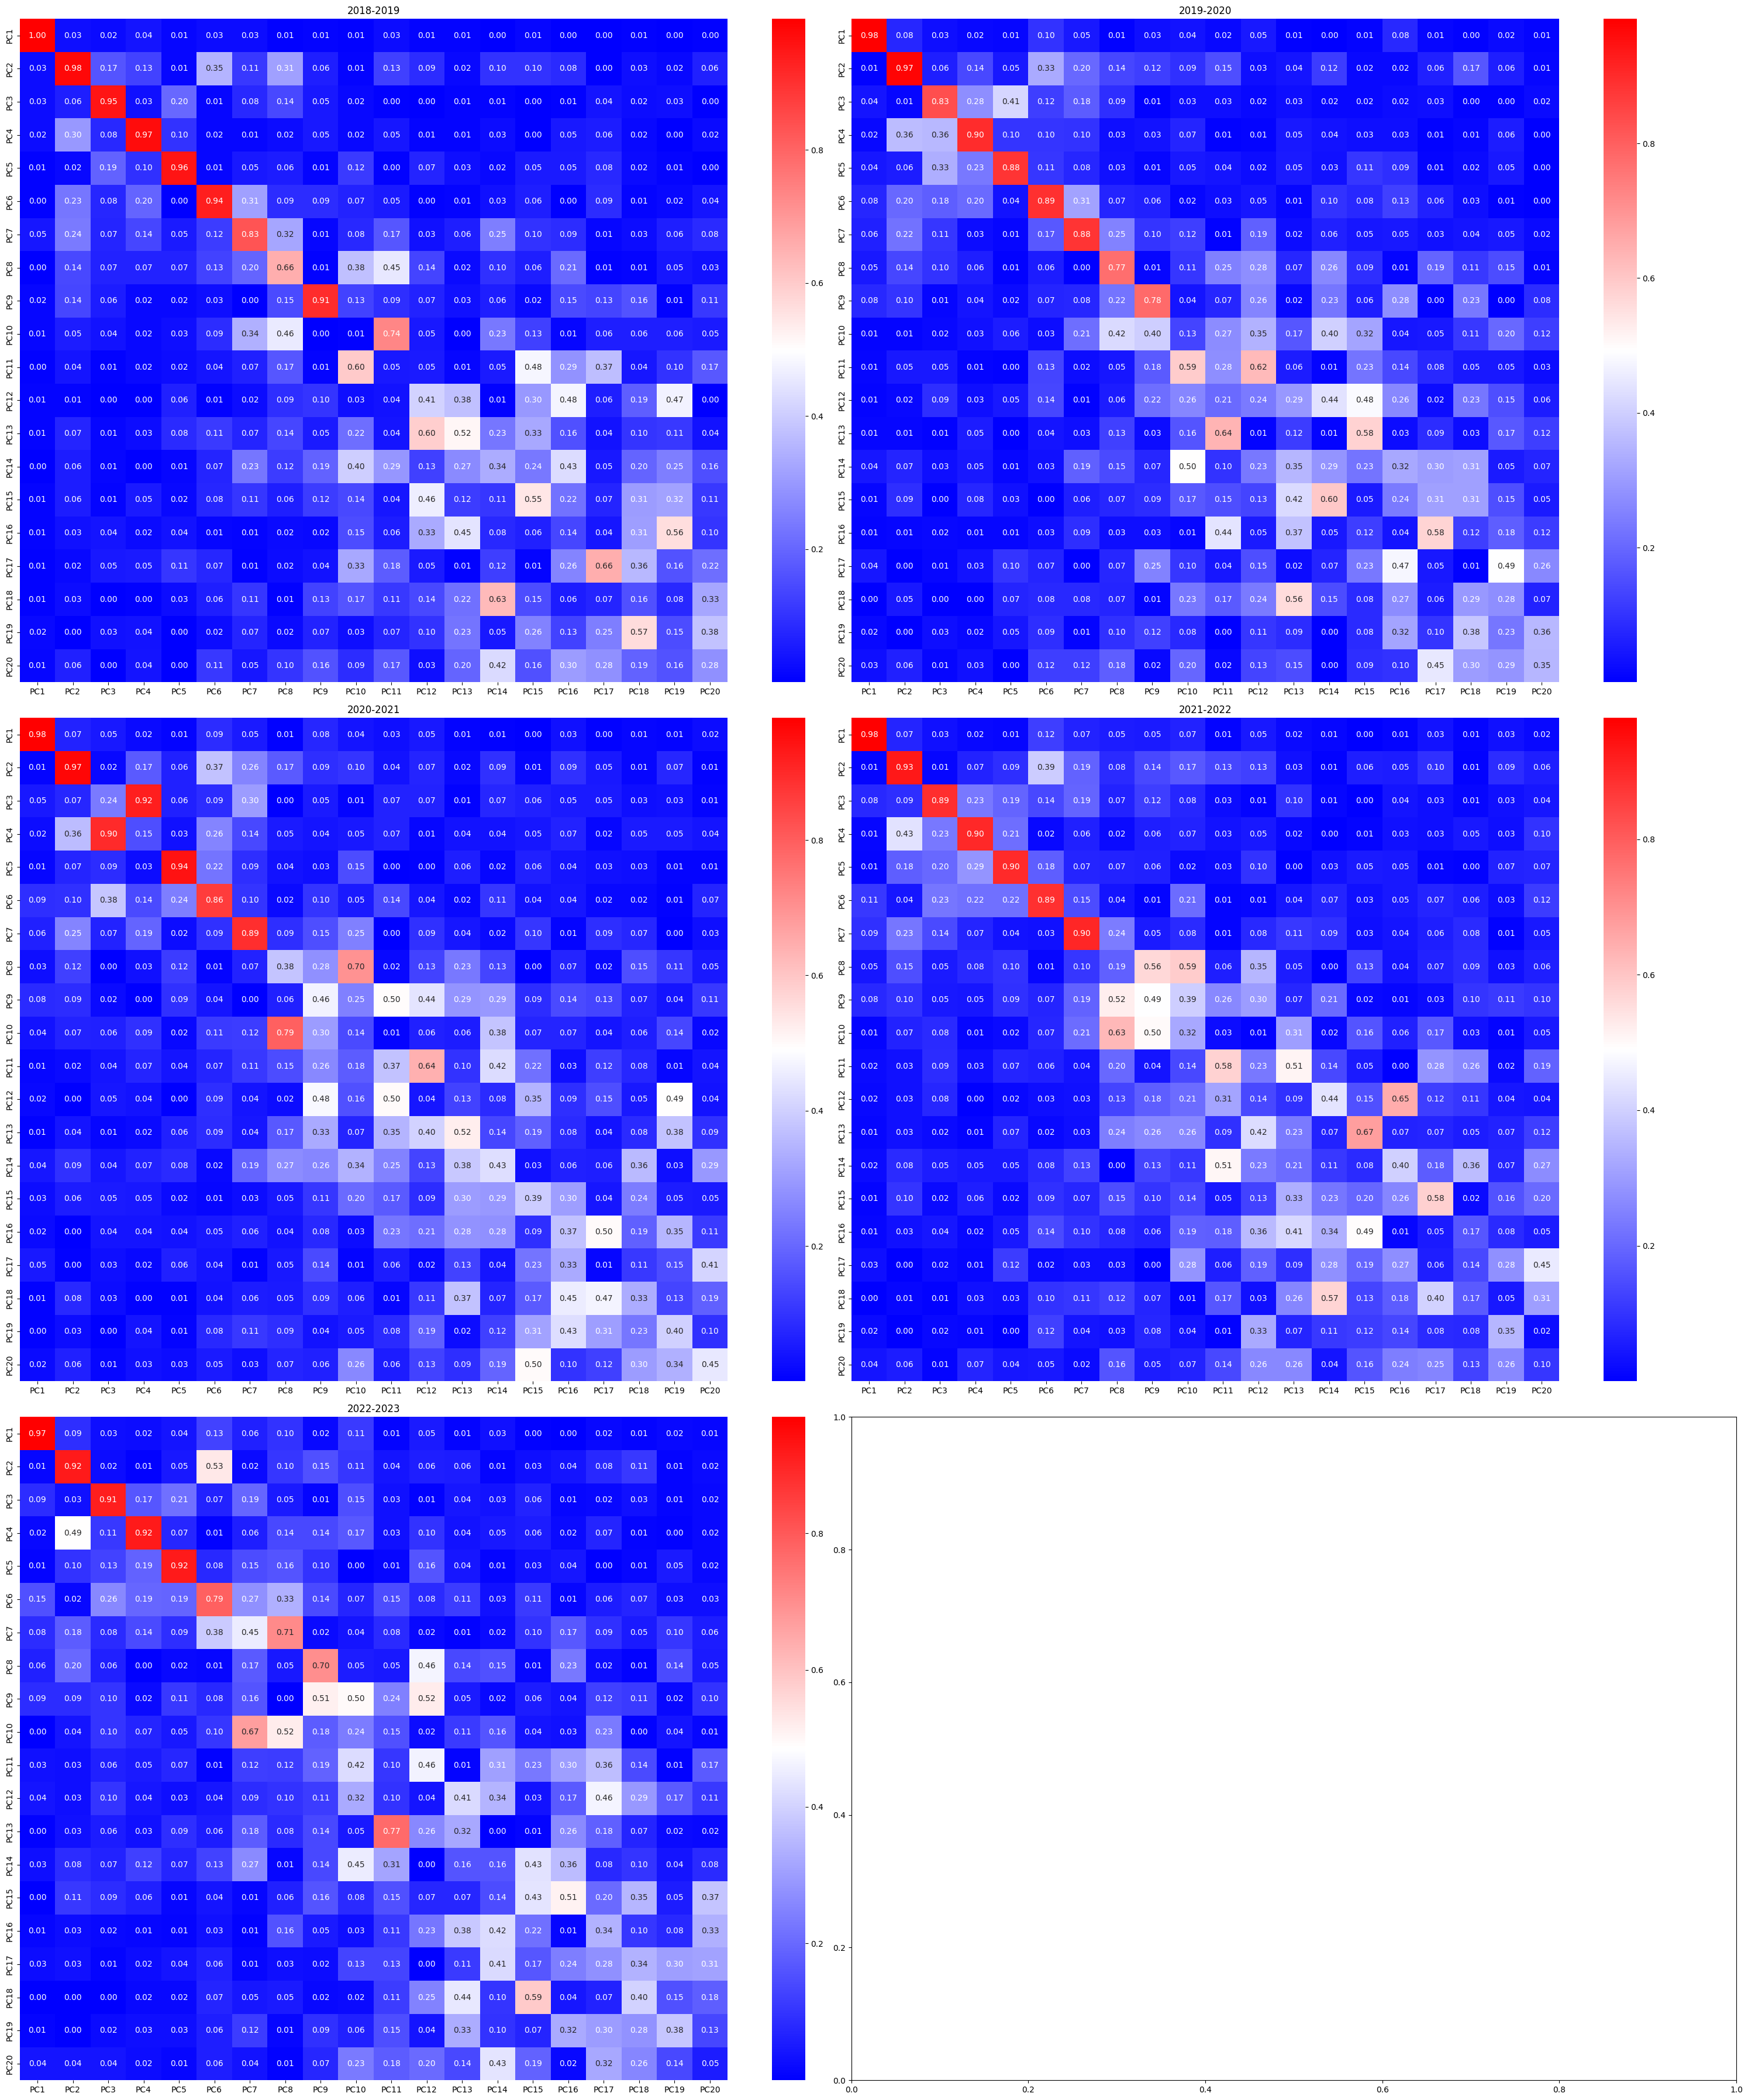

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(30, 36), tight_layout=True)
for i, (season, corr_mat) in enumerate(corr_mats.items()):
    row, col = i // 2, i % 2
    ax[row, col].set_title(season)
    sns.heatmap(np.abs(corr_mat[:20, :20]), annot=True, cmap='bwr', fmt=".2f", ax=ax[row, col])
    ax[row, col].set_xticks(np.arange(20) + 0.5)
    ax[row, col].set_xticklabels([f"PC{i}" for i in range(1, 21)])
    ax[row, col].set_yticks(np.arange(20) + 0.5)
    ax[row, col].set_yticklabels([f"PC{i}" for i in range(1, 21)])


plt.show()

To account for "flipping PC" I will find the correlations that make the most sense and pair them

In [8]:
def find_highest_correlations(matrix):
    correlations = []

    while matrix.size > 1:
        # Find the indices of the maximum correlation value
        max_corr = np.max(matrix[0])
        max_corr_col = np.argmax(matrix[0])

        # Add the highest correlation along with its index to the list
        correlations.append(max_corr)

        # Remove the row and column corresponding to the highest correlation
        matrix = np.delete(matrix, 0, axis=0)
        matrix = np.delete(matrix, max_corr_col, axis=1)

    return correlations

In [9]:
corr_vectors = []
for corr_mat in corr_mats.values():
    corr_vector = find_highest_correlations(np.abs(corr_mat))
    corr_vectors.append(corr_vector)

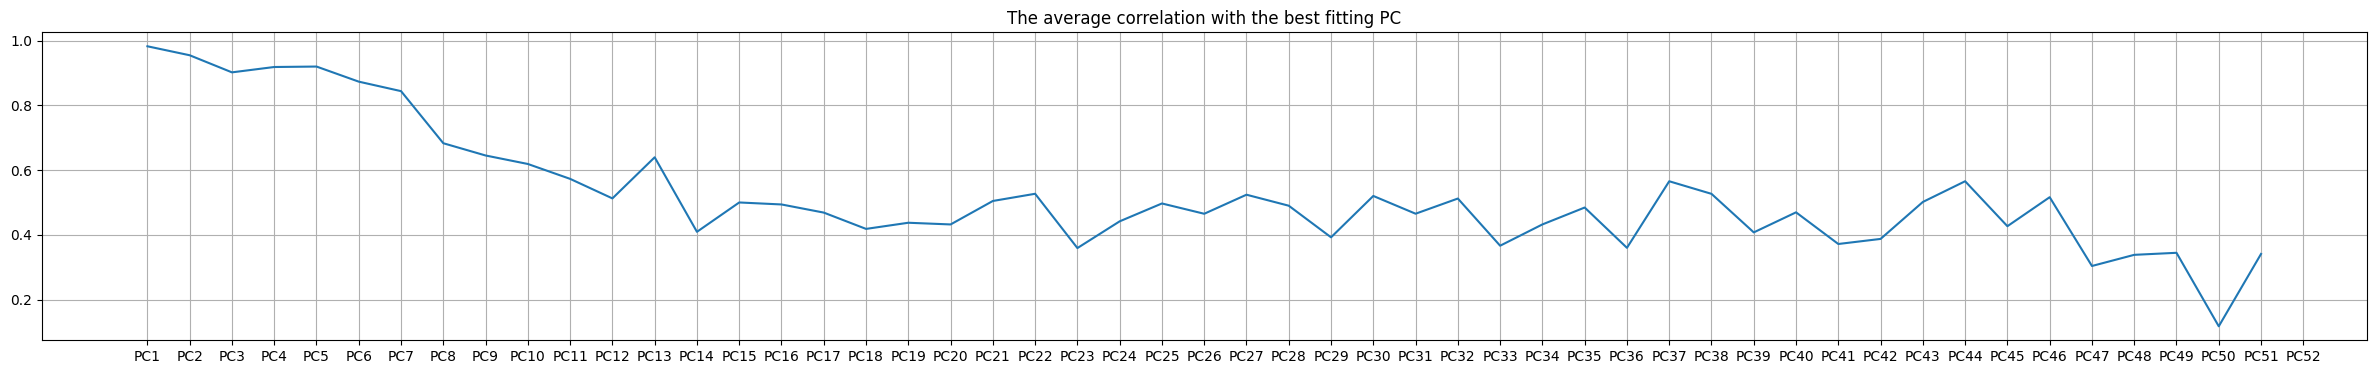

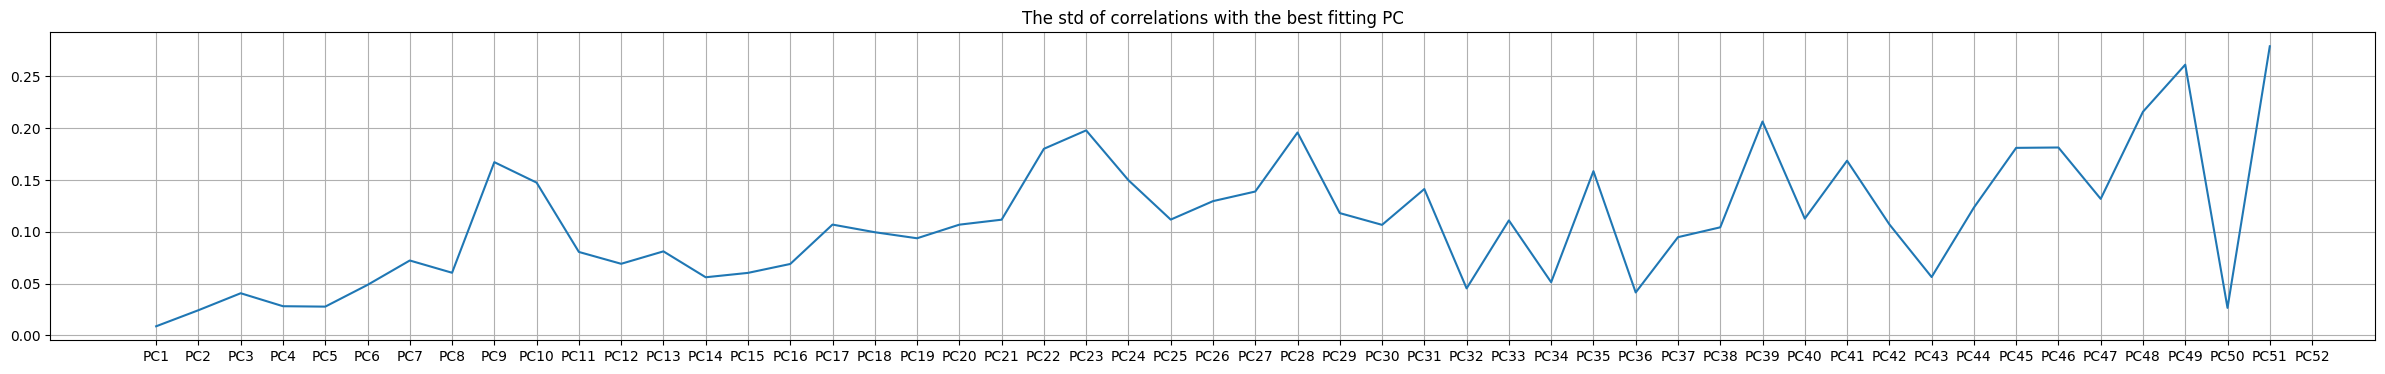

In [10]:
plt.figure(figsize=(30, 4))
plt.title("The average correlation with the best fitting PC")
plt.plot(np.mean(corr_vectors, axis=0))
plt.xticks(range(52), (f"PC{i}" for i in range(1, len(X_train.columns) + 1)))
plt.grid()
plt.show()

plt.figure(figsize=(30, 4))
plt.title("The std of correlations with the best fitting PC")
plt.plot(np.std(corr_vectors, axis=0))
plt.xticks(range(52), (f"PC{i}" for i in range(1, len(X_train.columns) + 1)))
plt.grid()
plt.show()

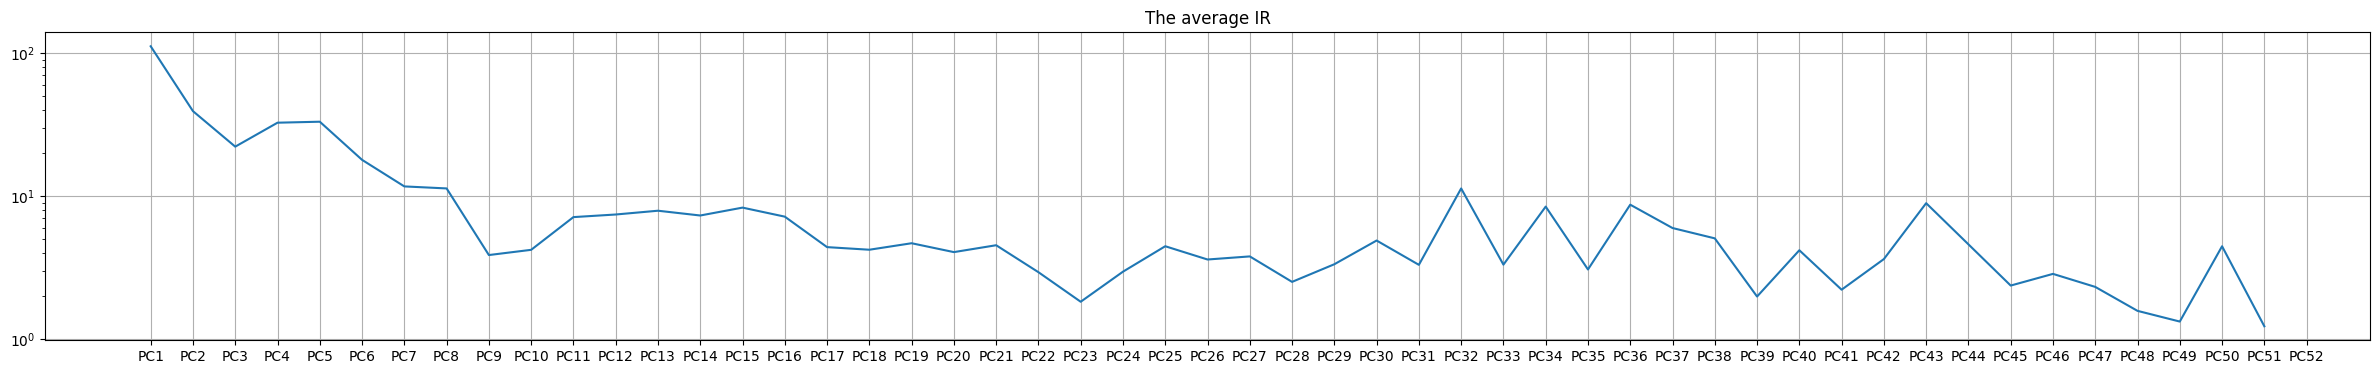

In [11]:
plt.figure(figsize=(30, 4))
plt.title("The average IR")
plt.plot(np.mean(corr_vectors, axis=0) / np.std(corr_vectors, axis=0))
plt.xticks(range(52), (f"PC{i}" for i in range(1, len(X_train.columns) + 1)))
plt.yscale('log')
plt.grid()
plt.show()